In [322]:
import numpy as np
import pandas as pd
from pandas_datareader import data as wb
import matplotlib.pyplot as plt
%matplotlib inline

In [323]:
data=wb.DataReader("SSL", data_source = 'yahoo', start = '2010-1-1')

In [324]:
#closing price vs adj closing depending on the real life application. For day trading where you are wanting to trade
# a cfd the closing price is best. The adjusted price would if you are holding the stock and dividends/splits play a
#role in your end return
data['movement %'] = (data["Close"]/data["Close"].shift(1)-1)*100

In [325]:
data['Target'] = data['movement %'].apply(lambda x : "Up" if x >0 else "Down")

In [326]:
#drop the first column
data=data.iloc[1:]

In [327]:
data.head()

,High,Low,Open,Close,Volume,Adj Close,movement %,Target
Date,,,,,,,,
2010-01-05,41.919998,41.610001,41.720001,41.799999,169200.0,28.939795,0.119759,Up
2010-01-06,42.150002,41.590000,41.590000,42.139999,259400.0,29.175188,0.813398,Up
2010-01-07,42.000000,41.400002,41.480000,41.919998,212800.0,29.022886,-0.522072,Down
2010-01-08,42.549999,41.750000,41.889999,42.439999,212100.0,29.382904,1.240459,Up
2010-01-11,43.400002,42.849998,42.900002,42.980000,244800.0,29.756765,1.272387,Up


## Display Price over Time

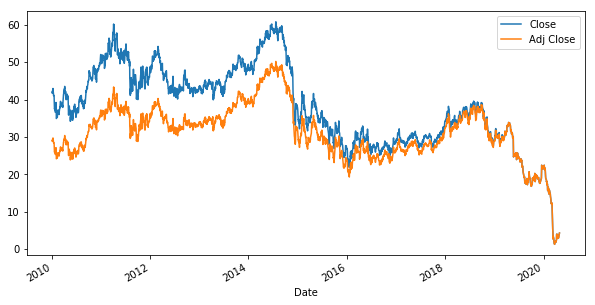

In [328]:
data[["Close","Adj Close"]].plot(figsize=(10, 5))

In [329]:
std_close = (data["Close"]-data["Close"].shift(1)).std()
std_vol = (data["Volume"]-data["Volume"].shift(1)).std()

In [342]:
std_close

0.7667770984612836

In [330]:
def close(A,B):
    if (A["Close"] - B["Close"])>std_close*2:
        return "L"
    elif (A["Close"] - B["Close"]) <std_close:
        return "S"
    else: return "M"

def volume(A,B):
    if (A["Volume"] - B["Volume"])>std_vol*2:
        return "L"
    elif (A["Volume"] - B["Volume"]) <std_vol:
        return "S"
    else: return "M"

In [331]:
def data2features(data,i):
    A=data.iloc[i]
    A_1=data.iloc[i-1]
    
    features = {
    "close":close(A,A_1),
    "volume": volume(A,A_1)
    }
    return features
    

In [333]:
data2features(data,1)

{'close': 'S', 'volume': 'S'}

In [334]:
X_train = []
for i in range(1,data.shape[0]):
    X_train.append(data2features(data,i))
X_train = [X_train]

In [335]:
Y_train=[list(data["Target"].shift(-1))[:-1]]

In [338]:
#Model
from sklearn_crfsuite import CRF

#Evalulation
from sklearn.model_selection import cross_val_predict
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn_crfsuite.metrics import flat_f1_score
from sklearn_crfsuite.metrics import flat_accuracy_score

In [341]:
%%time
crf4 = CRF(algorithm='lbfgs',
           max_iterations=20,
           c1=0.1,
           c2=0.2,
           all_possible_transitions=False)

#training model
crf4.fit(X=X_train, y=Y_train)

#generate predictions
pred = crf4.predict(X_train)

#generate report on entire model
report = flat_classification_report(y_pred=pred, y_true=Y_train)
print(report)

acc = flat_accuracy_score(y_pred=pred, y_true=Y_train)
print("F1=%.2f"%(acc*100))

              precision    recall  f1-score   support

        Down       0.57      1.00      0.73      1295
          Up       1.00      0.25      0.39      1300

   micro avg       0.62      0.62      0.62      2595
   macro avg       0.78      0.62      0.56      2595
weighted avg       0.78      0.62      0.56      2595

F1=62.20
CPU times: user 58.4 ms, sys: 4.31 ms, total: 62.7 ms
Wall time: 68 ms
